# Method 7 - Best Ideas High Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[best_ideas['focus_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

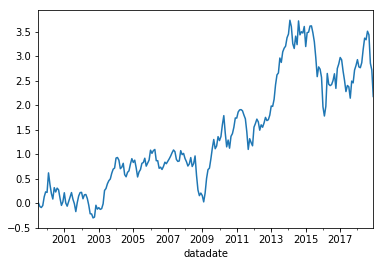

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.228728
2000-12-31   -0.165921
2001-12-31    0.185028
2002-12-31   -0.278681
2003-12-31    0.958294
2004-12-31    0.111296
2005-12-31   -0.015050
2006-12-31   -0.039515
2007-12-31    0.116394
2008-12-31   -0.401732
2009-12-31    0.955567
2010-12-31    0.161783
2011-12-31   -0.207428
2012-12-31    0.288749
2013-12-31    0.565030
2014-12-31    0.052300
2015-12-31   -0.225380
2016-12-31    0.076699
2017-12-31   -0.008373
2018-12-31   -0.166066
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     250.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.95e-82
Time:                        21:24:38   Log-Likelihood:                 438.46
No. Observations:                 234   AIC:                            -866.9
Df Residuals:                     229   BIC:                            -849.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.003      1.777      0.077      -0.000       0.010
mktrf          0.9350      0.070     13.349      0.000       0.797       1.073
me             0.9202      0.081     11.293      0.000       0.760       1.081
ia             0.0902      0.124      0.729      0.467      -0.154       0.334
roe           -0.9590      0.106     -9.047      0.000      -1.168      -0.750
==============================================================================
Omnibus:                       46.082   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.386
Skew:                           0.952   Prob(JB):                     7.13e-22
Kurtosis:                       5.522   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     261.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.00e-84
Time:                        21:24:38   Log-Likelihood:                 438.46
No. Observations:                 234   AIC:                            -866.9
Df Residuals:                     229   BIC:                            -849.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.003      1.596      0.111      -0.001       0.010
mktrf          0.9350      0.077     12.193      0.000       0.785       1.085
me             0.9202      0.080     11.492      0.000       0.763       1.077
ia             0.0902      0.168      0.536      0.592      -0.240       0.420
roe           -0.9590      0.190     -5.058      0.000      -1.331      -0.587
==============================================================================
Omnibus:                       46.082   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.386
Skew:                           0.952   Prob(JB):                     7.13e-22
Kurtosis:                       5.522   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     264.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.32e-84
Time:                        21:24:38   Log-Likelihood:                 438.46
No. Observations:                 234   AIC:                            -866.9
Df Residuals:                     229   BIC:                            -849.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.003      1.517      0.129      -0.001       0.010
mktrf          0.9350      0.078     11.938      0.000       0.781       1.089
me             0.9202      0.090     10.272      0.000       0.745       1.096
ia             0.0902      0.179      0.503      0.615      -0.261       0.442
roe           -0.9590      0.205     -4.680      0.000      -1.361      -0.557
==============================================================================
Omnibus:                       46.082   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.386
Skew:                           0.952   Prob(JB):                     7.13e-22
Kurtosis:                       5.522   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     192.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.44e-80
Time:                        21:24:38   Log-Likelihood:                 435.12
No. Observations:                 234   AIC:                            -858.2
Df Residuals:                     228   BIC:                            -837.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.003      1.218      0.224      -0.002       0.008
mktrf          1.0731      0.071     15.040      0.000       0.932       1.214
smb            0.9941      0.094     10.559      0.000       0.809       1.180
hml           -0.0458      0.111     -0.413      0.680      -0.265       0.173
rmw           -0.7652      0.126     -6.096      0.000      -1.012      -0.518
cma            0.2915      0.160      1.827      0.069      -0.023       0.606
==============================================================================
Omnibus:                       59.140   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.355
Skew:                           1.118   Prob(JB):                     1.84e-34
Kurtosis:                       6.307   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     264.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.08e-92
Time:                        21:24:38   Log-Likelihood:                 435.12
No. Observations:                 234   AIC:                            -858.2
Df Residuals:                     228   BIC:                            -837.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.003      1.135      0.256      -0.002       0.009
mktrf          1.0731      0.058     18.401      0.000       0.959       1.187
smb            0.9941      0.084     11.777      0.000       0.829       1.160
hml           -0.0458      0.151     -0.304      0.761      -0.342       0.250
rmw           -0.7652      0.191     -4.000      0.000      -1.140      -0.390
cma            0.2915      0.221      1.321      0.187      -0.141       0.724
==============================================================================
Omnibus:                       59.140   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.355
Skew:                           1.118   Prob(JB):                     1.84e-34
Kurtosis:                       6.307   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     273.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.18e-94
Time:                        21:24:38   Log-Likelihood:                 435.12
No. Observations:                 234   AIC:                            -858.2
Df Residuals:                     228   BIC:                            -837.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.003      1.078      0.281      -0.003       0.009
mktrf          1.0731      0.059     18.252      0.000       0.958       1.188
smb            0.9941      0.088     11.321      0.000       0.822       1.166
hml           -0.0458      0.143     -0.321      0.748      -0.325       0.234
rmw           -0.7652      0.211     -3.626      0.000      -1.179      -0.352
cma            0.2915      0.219      1.333      0.183      -0.137       0.720
==============================================================================
Omnibus:                       59.140   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.355
Skew:                           1.118   Prob(JB):                     1.84e-34
Kurtosis:                       6.307   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     227.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.59e-78
Time:                        21:24:38   Log-Likelihood:                 429.24
No. Observations:                 234   AIC:                            -848.5
Df Residuals:                     229   BIC:                            -831.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.003      0.630      0.529      -0.003       0.007
mktrf          1.0991      0.067     16.384      0.000       0.967       1.231
smb            1.3326      0.084     15.914      0.000       1.168       1.498
hml           -0.0037      0.083     -0.045      0.964      -0.168       0.160
umd           -0.2828      0.055     -5.182      0.000      -0.390      -0.175
==============================================================================
Omnibus:                       70.984   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              271.377
Skew:                           1.194   Prob(JB):                     1.18e-59
Kurtosis:                       7.705   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     275.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.96e-86
Time:                        21:24:38   Log-Likelihood:                 429.24
No. Observations:                 234   AIC:                            -848.5
Df Residuals:                     229   BIC:                            -831.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.003      0.612      0.540      -0.004       0.007
mktrf          1.0991      0.053     20.565      0.000       0.994       1.204
smb            1.3326      0.083     16.085      0.000       1.170       1.495
hml           -0.0037      0.105     -0.036      0.972      -0.209       0.201
umd           -0.2828      0.079     -3.560      0.000      -0.439      -0.127
==============================================================================
Omnibus:                       70.984   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              271.377
Skew:                           1.194   Prob(JB):                     1.18e-59
Kurtosis:                       7.705   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     253.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.73e-83
Time:                        21:24:39   Log-Likelihood:                 429.24
No. Observations:                 234   AIC:                            -848.5
Df Residuals:                     229   BIC:                            -831.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.003      0.583      0.560      -0.004       0.007
mktrf          1.0991      0.048     22.669      0.000       1.004       1.194
smb            1.3326      0.085     15.675      0.000       1.166       1.499
hml           -0.0037      0.103     -0.036      0.971      -0.206       0.199
umd           -0.2828      0.084     -3.351      0.001      -0.448      -0.117
==============================================================================
Omnibus:                       70.984   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              271.377
Skew:                           1.194   Prob(JB):                     1.18e-59
Kurtosis:                       7.705   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     143.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.14e-43
Time:                        21:24:39   Log-Likelihood:                 212.42
No. Observations:                 120   AIC:                            -414.8
Df Residuals:                     115   BIC:                            -400.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0092      0.004      2.277      0.025       0.001       0.017
mktrf          0.9447      0.109      8.707      0.000       0.730       1.160
me             0.9627      0.107      8.984      0.000       0.750       1.175
ia            -0.0686      0.168     -0.409      0.684      -0.401       0.264
roe           -0.8653      0.149     -5.825      0.000      -1.159      -0.571
==============================================================================
Omnibus:                       24.176   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.851
Skew:                           0.886   Prob(JB):                     4.96e-10
Kurtosis:                       5.330   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     213.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.03e-52
Time:                        21:24:39   Log-Likelihood:                 212.42
No. Observations:                 120   AIC:                            -414.8
Df Residuals:                     115   BIC:                            -400.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0092      0.005      2.002      0.045       0.000       0.018
mktrf          0.9447      0.116      8.115      0.000       0.717       1.173
me             0.9627      0.105      9.172      0.000       0.757       1.168
ia            -0.0686      0.228     -0.301      0.763      -0.515       0.378
roe           -0.8653      0.262     -3.302      0.001      -1.379      -0.352
==============================================================================
Omnibus:                       24.176   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.851
Skew:                           0.886   Prob(JB):                     4.96e-10
Kurtosis:                       5.330   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     234.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.74e-54
Time:                        21:24:39   Log-Likelihood:                 212.42
No. Observations:                 120   AIC:                            -414.8
Df Residuals:                     115   BIC:                            -400.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0092      0.005      1.894      0.058      -0.000       0.019
mktrf          0.9447      0.125      7.569      0.000       0.700       1.189
me             0.9627      0.117      8.239      0.000       0.734       1.192
ia            -0.0686      0.227     -0.302      0.762      -0.513       0.376
roe           -0.8653      0.289     -2.995      0.003      -1.431      -0.299
==============================================================================
Omnibus:                       24.176   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.851
Skew:                           0.886   Prob(JB):                     4.96e-10
Kurtosis:                       5.330   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     125.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.33e-44
Time:                        21:24:39   Log-Likelihood:                 217.38
No. Observations:                 120   AIC:                            -422.8
Df Residuals:                     114   BIC:                            -406.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.004      2.232      0.028       0.001       0.017
mktrf          1.1954      0.110     10.842      0.000       0.977       1.414
smb            1.0769      0.125      8.624      0.000       0.830       1.324
hml           -0.2493      0.153     -1.629      0.106      -0.552       0.054
rmw           -0.5401      0.180     -2.993      0.003      -0.898      -0.183
cma            0.3474      0.198      1.758      0.082      -0.044       0.739
==============================================================================
Omnibus:                       18.927   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.410
Skew:                           0.753   Prob(JB):                     4.11e-07
Kurtosis:                       4.902   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     206.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.23e-55
Time:                        21:24:39   Log-Likelihood:                 217.38
No. Observations:                 120   AIC:                            -422.8
Df Residuals:                     114   BIC:                            -406.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.004      2.108      0.035       0.001       0.017
mktrf          1.1954      0.081     14.817      0.000       1.037       1.353
smb            1.0769      0.098     10.964      0.000       0.884       1.269
hml           -0.2493      0.177     -1.412      0.158      -0.596       0.097
rmw           -0.5401      0.247     -2.187      0.029      -1.024      -0.056
cma            0.3474      0.251      1.386      0.166      -0.144       0.839
==============================================================================
Omnibus:                       18.927   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.410
Skew:                           0.753   Prob(JB):                     4.11e-07
Kurtosis:                       4.902   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     349.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.39e-67
Time:                        21:24:39   Log-Likelihood:                 217.38
No. Observations:                 120   AIC:                            -422.8
Df Residuals:                     114   BIC:                            -406.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.005      1.947      0.052   -5.91e-05       0.018
mktrf          1.1954      0.081     14.828      0.000       1.037       1.353
smb            1.0769      0.095     11.370      0.000       0.891       1.263
hml           -0.2493      0.163     -1.525      0.127      -0.570       0.071
rmw           -0.5401      0.275     -1.961      0.050      -1.080      -0.000
cma            0.3474      0.237      1.467      0.142      -0.117       0.812
==============================================================================
Omnibus:                       18.927   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.410
Skew:                           0.753   Prob(JB):                     4.11e-07
Kurtosis:                       4.902   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     157.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.05e-45
Time:                        21:24:39   Log-Likelihood:                 217.32
No. Observations:                 120   AIC:                            -424.6
Df Residuals:                     115   BIC:                            -410.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.004      1.985      0.050    1.57e-05       0.015
mktrf          1.1441      0.092     12.468      0.000       0.962       1.326
smb            1.3629      0.104     13.045      0.000       1.156       1.570
hml           -0.1043      0.105     -0.997      0.321      -0.312       0.103
umd           -0.2699      0.065     -4.183      0.000      -0.398      -0.142
==============================================================================
Omnibus:                       32.635   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.046
Skew:                           1.077   Prob(JB):                     1.37e-16
Kurtosis:                       6.158   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     432.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.58e-68
Time:                        21:24:39   Log-Likelihood:                 217.32
No. Observations:                 120   AIC:                            -424.6
Df Residuals:                     115   BIC:                            -410.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.003      2.239      0.025       0.001       0.014
mktrf          1.1441      0.059     19.477      0.000       1.029       1.259
smb            1.3629      0.101     13.504      0.000       1.165       1.561
hml           -0.1043      0.142     -0.734      0.463      -0.383       0.174
umd           -0.2699      0.086     -3.149      0.002      -0.438      -0.102
==============================================================================
Omnibus:                       32.635   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.046
Skew:                           1.077   Prob(JB):                     1.37e-16
Kurtosis:                       6.158   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     439.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-68
Time:                        21:24:39   Log-Likelihood:                 217.32
No. Observations:                 120   AIC:                            -424.6
Df Residuals:                     115   BIC:                            -410.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.003      2.255      0.024       0.001       0.014
mktrf          1.1441      0.048     23.943      0.000       1.050       1.238
smb            1.3629      0.102     13.378      0.000       1.163       1.563
hml           -0.1043      0.145     -0.719      0.472      -0.389       0.180
umd           -0.2699      0.090     -3.006      0.003      -0.446      -0.094
==============================================================================
Omnibus:                       32.635   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.046
Skew:                           1.077   Prob(JB):                     1.37e-16
Kurtosis:                       6.158   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     107.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.55e-37
Time:                        21:24:39   Log-Likelihood:                 236.37
No. Observations:                 114   AIC:                            -462.7
Df Residuals:                     109   BIC:                            -449.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.003     -0.295      0.769      -0.007       0.005
mktrf          1.0145      0.091     11.088      0.000       0.833       1.196
me             0.6747      0.141      4.777      0.000       0.395       0.955
ia             0.3765      0.196      1.921      0.057      -0.012       0.765
roe           -1.1663      0.172     -6.774      0.000      -1.507      -0.825
==============================================================================
Omnibus:                       31.619   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.236
Skew:                           1.128   Prob(JB):                     1.13e-14
Kurtosis:                       5.905   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     237.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.85e-53
Time:                        21:24:39   Log-Likelihood:                 236.37
No. Observations:                 114   AIC:                            -462.7
Df Residuals:                     109   BIC:                            -449.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.002     -0.393      0.694      -0.005       0.004
mktrf          1.0145      0.070     14.538      0.000       0.878       1.151
me             0.6747      0.136      4.969      0.000       0.409       0.941
ia             0.3765      0.221      1.703      0.089      -0.057       0.810
roe           -1.1663      0.308     -3.791      0.000      -1.769      -0.563
==============================================================================
Omnibus:                       31.619   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.236
Skew:                           1.128   Prob(JB):                     1.13e-14
Kurtosis:                       5.905   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     370.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.81e-62
Time:                        21:24:39   Log-Likelihood:                 236.37
No. Observations:                 114   AIC:                            -462.7
Df Residuals:                     109   BIC:                            -449.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.002     -0.452      0.651      -0.005       0.003
mktrf          1.0145      0.055     18.431      0.000       0.907       1.122
me             0.6747      0.148      4.559      0.000       0.385       0.965
ia             0.3765      0.247      1.525      0.127      -0.107       0.860
roe           -1.1663      0.299     -3.899      0.000      -1.752      -0.580
==============================================================================
Omnibus:                       31.619   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.236
Skew:                           1.128   Prob(JB):                     1.13e-14
Kurtosis:                       5.905   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     69.29
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.13e-32
Time:                        21:24:39   Log-Likelihood:                 227.32
No. Observations:                 114   AIC:                            -442.6
Df Residuals:                     108   BIC:                            -426.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.003     -0.995      0.322      -0.010       0.003
mktrf          1.0709      0.095     11.284      0.000       0.883       1.259
smb            0.7645      0.154      4.962      0.000       0.459       1.070
hml            0.2289      0.196      1.165      0.247      -0.161       0.618
rmw           -0.8943      0.241     -3.717      0.000      -1.371      -0.417
cma            0.2119      0.305      0.694      0.489      -0.394       0.817
==============================================================================
Omnibus:                       55.999   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              246.881
Skew:                           1.630   Prob(JB):                     2.46e-54
Kurtosis:                       9.430   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     150.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.02e-47
Time:                        21:24:39   Log-Likelihood:                 227.32
No. Observations:                 114   AIC:                            -442.6
Df Residuals:                     108   BIC:                            -426.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.003     -1.236      0.217      -0.009       0.002
mktrf          1.0709      0.072     14.792      0.000       0.929       1.213
smb            0.7645      0.136      5.632      0.000       0.498       1.031
hml            0.2289      0.124      1.843      0.065      -0.015       0.472
rmw           -0.8943      0.382     -2.343      0.019      -1.642      -0.146
cma            0.2119      0.292      0.726      0.468      -0.360       0.784
==============================================================================
Omnibus:                       55.999   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              246.881
Skew:                           1.630   Prob(JB):                     2.46e-54
Kurtosis:                       9.430   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     240.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.63e-57
Time:                        21:24:39   Log-Likelihood:                 227.32
No. Observations:                 114   AIC:                            -442.6
Df Residuals:                     108   BIC:                            -426.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.002     -1.475      0.140      -0.008       0.001
mktrf          1.0709      0.073     14.580      0.000       0.927       1.215
smb            0.7645      0.163      4.692      0.000       0.445       1.084
hml            0.2289      0.114      2.009      0.045       0.006       0.452
rmw           -0.8943      0.415     -2.157      0.031      -1.707      -0.082
cma            0.2119      0.347      0.611      0.541      -0.468       0.891
==============================================================================
Omnibus:                       55.999   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              246.881
Skew:                           1.630   Prob(JB):                     2.46e-54
Kurtosis:                       9.430   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     77.17
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.60e-31
Time:                        21:24:39   Log-Likelihood:                 221.98
No. Observations:                 114   AIC:                            -434.0
Df Residuals:                     109   BIC:                            -420.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.004     -1.141      0.256      -0.011       0.003
mktrf          1.1035      0.098     11.219      0.000       0.909       1.298
smb            0.9617      0.153      6.270      0.000       0.658       1.266
hml            0.3791      0.158      2.400      0.018       0.066       0.692
umd           -0.2478      0.119     -2.079      0.040      -0.484      -0.012
==============================================================================
Omnibus:                       53.497   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.119
Skew:                           1.461   Prob(JB):                     1.49e-61
Kurtosis:                      10.101   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     240.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.98e-53
Time:                        21:24:39   Log-Likelihood:                 221.98
No. Observations:                 114   AIC:                            -434.0
Df Residuals:                     109   BIC:                            -420.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.003     -1.283      0.199      -0.010       0.002
mktrf          1.1035      0.077     14.300      0.000       0.952       1.255
smb            0.9617      0.118      8.177      0.000       0.731       1.192
hml            0.3791      0.153      2.486      0.013       0.080       0.678
umd           -0.2478      0.096     -2.593      0.010      -0.435      -0.060
==============================================================================
Omnibus:                       53.497   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.119
Skew:                           1.461   Prob(JB):                     1.49e-61
Kurtosis:                      10.101   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     344.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.86e-61
Time:                        21:24:39   Log-Likelihood:                 221.98
No. Observations:                 114   AIC:                            -434.0
Df Residuals:                     109   BIC:                            -420.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.003     -1.311      0.190      -0.010       0.002
mktrf          1.1035      0.074     14.821      0.000       0.958       1.249
smb            0.9617      0.101      9.489      0.000       0.763       1.160
hml            0.3791      0.142      2.672      0.008       0.101       0.657
umd           -0.2478      0.078     -3.158      0.002      -0.402      -0.094
==============================================================================
Omnibus:                       53.497   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.119
Skew:                           1.461   Prob(JB):                     1.49e-61
Kurtosis:                      10.101   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""